# Decision Trees & Missing Values

In this notebook I will implement decision tree models that can handle missing values. Examples will be considered for both classification and regression cases. Synethetic data will be used to test both use cases. The implemented models will be compared to the decision trees available through scikit-learn.

In [1]:
# imports
from __future__ import annotations
from typing import Tuple
from abc import ABC,abstractmethod
from scipy import stats
from random import choices
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification,make_regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_squared_error,mean_absolute_error

In [2]:
class Node(object):
    """
    Class to define & control tree nodes
    """
    
    def __init__(self) -> None:
        """
        Initializer for a Node class instance
        """
        self.__split    = None
        self.__feature  = None
        self.__left     = None
        self.__right    = None
        self.leaf_value = None

    def set_params(self, split: float, feature: int) -> None:
        """
        Set the split & feature parameters for this node
        
        Input:
            split   -> value to split feature on
            feature -> index of feature to be used in splitting 
        """
        self.__split   = split
        self.__feature = feature
        
    def get_params(self) -> Tuple[float,int]:
        """
        Get the split & feature parameters for this node
        
        Output:
            Tuple containing (split,feature) pair
        """
        return(self.__split, self.__feature)    
        
    def set_children(self, left: Node, right: Node) -> None:
        """
        Set the left/right child nodes for the current node
        
        Inputs:
            left  -> LHS child node
            right -> RHS child node
        """
        self.__left  = left
        self.__right = right
        
    def get_left_node(self) -> Node:
        """
        Get the left child node
        
        Output:
            LHS child node
        """
        return(self.__left)
    
    def get_right_node(self) -> Node:
        """
        Get the RHS child node
        
        Output:
            RHS child node
        """
        return(self.__right)

In [3]:
class DecisionTree(ABC):
    """
    Base class to encompass the CART algorithm
    """
    
    def __init__(self, max_depth: int=None, min_samples_split: int=2, nans_go_right=True) -> None:
        """
        Initializer
        
        Inputs:
            max_depth         -> maximum depth the tree can grow
            min_samples_split -> minimum number of samples required to split a node
            nans_go_right     -> boolean to determine where NaN values in predictors are allocated
        """
        self.tree              = None
        self.max_depth         = max_depth
        self.min_samples_split = min_samples_split
        self.nans_go_right     = nans_go_right
        
    @abstractmethod
    def _impurity(self, D: np.array) -> None:
        """
        Protected function to define the impurity
        """
        pass
        
    @abstractmethod
    def _leaf_value(self, D: np.array) -> None:
        """
        Protected function to compute the value at a leaf node
        """
        pass
        
    def __split_right(self, feature_col: np.array, split_point: float) -> np.array:
        """
        Private function to determine which elements in the feature column go to the child right node
        
        Inputs:
            feature_col -> feature column to analyse
            split_point -> split point for the feature column
        Outputs:
            numpy array of boolean values
        """
        return (feature_col > split_point) | (np.isnan(feature_col) & self.nans_go_right)
 
    def __split_left(self, feature_col: np.array, split_point: float) -> np.array:
        """
        Private function to determine which elements in the feature column go to the child left node
        
        Inputs:
            feature_col -> feature column to analyse
            split_point -> split point for the feature column
        Outputs:
            numpy array of boolean values
        """
        return (feature_col <= split_point) | (np.isnan(feature_col) & (not self.nans_go_right))

    def __grow(self, node: Node, D: np.array, level: int) -> None:
        """
        Private recursive function to grow the tree during training
        
        Inputs:
            node  -> input tree node
            D     -> sample of data at node 
            level -> depth level in the tree for node
        """
        # are we in a leaf node?
        depth = (self.max_depth is None) or (self.max_depth >= (level+1))
        msamp = (self.min_samples_split <= D.shape[0])
        cls   = D[:,-1]
        n_cls = np.unique(cls[~np.isnan(cls)]).shape[0] != 1
        
        # not a leaf node
        if depth and msamp and n_cls:
        
            # initialize the function parameters
            ip_node = None
            feature = None
            split   = None
            left_D  = None
            right_D = None
            # iterate through the possible feature/split combinations
            for f in range(D.shape[1]-1):
                f_values = D[:,f]
                for s in np.unique(f_values[~np.isnan(f_values)]):
                    # for the current (f,s) combination, split the dataset
                    D_l = D[self.__split_left(D[:,f],s)]
                    D_r = D[self.__split_right(D[:,f],s)]
                    # ensure we have non-empty arrays
                    if D_l.size and D_r.size:
                        # calculate the impurity
                        ip  = (D_l.shape[0]/D.shape[0])*self._impurity(D_l) + (D_r.shape[0]/D.shape[0])*self._impurity(D_r)
                        # now update the impurity and choice of (f,s)
                        if (ip_node is None) or (ip < ip_node):
                            ip_node = ip
                            feature = f
                            split   = s
                            left_D  = D_l
                            right_D = D_r
            # set the current node's parameters
            node.set_params(split,feature)
            # declare child nodes
            left_node  = Node()
            right_node = Node()
            node.set_children(left_node,right_node)
            # investigate child nodes
            self.__grow(node.get_left_node(),left_D,level+1)
            self.__grow(node.get_right_node(),right_D,level+1)
                        
        # is a leaf node
        else:
            
            # set the node value & return
            node.leaf_value = self._leaf_value(D)
            return
     
    def __traverse(self, node: Node, Xrow: np.array) -> int | float:
        """
        Private recursive function to traverse the (trained) tree
        
        Inputs:
            node -> current node in the tree
            Xrow -> data sample being considered
        Output:
            leaf value corresponding to Xrow
        """        
        # check if we're in a leaf node?
        if node.leaf_value is None:
            # get parameters at the node
            (s,f) = node.get_params()
            # decide to go left or right?
            if (self.__split_left(Xrow[f],s)):
                return(self.__traverse(node.get_left_node(),Xrow))
            else:
                # note nan's in Xrow will go right
                return(self.__traverse(node.get_right_node(),Xrow))
        else:
            # return the leaf value
            return(node.leaf_value)
    
    def train(self, Xin: np.array, Yin: np.array) -> None:
        """
        Train the CART model
        
        Inputs:
            Xin -> input set of predictor features
            Yin -> input set of labels
        """        
        # prepare the input data
        D            = np.concatenate((Xin,Yin.reshape(-1,1)),axis=1)
        D[D == None] = np.nan
        D            = D.astype('float64')
        # set the root node of the tree
        self.tree = Node()
        # build the tree
        self.__grow(self.tree,D,1)
        
    def predict(self, Xin: np.array) -> np.array:
        """
        Make predictions from the trained CART model
        
        Input:
            Xin -> input set of predictor features
        Output:
            array of prediction values
        """
        # prepare the input data
        Xin[Xin == None] = np.nan
        Xin              = Xin.astype('float64')
        # iterate through the rows of Xin
        p = []
        for r in range(Xin.shape[0]):
            p.append(self.__traverse(self.tree,Xin[r,:]))
        # return predictions
        return(np.array(p).flatten())

In [4]:
class DecisionTreeClassifier(DecisionTree):
    """
    Decision Tree Classifier
    """
    
    def __init__(self, max_depth: int=None, min_samples_split: int=2, nans_go_right=True, loss: str='gini') -> None:
        """
        Initializer
        
        Inputs:
            max_depth         -> maximum depth the tree can grow
            min_samples_split -> minimum number of samples required to split a node
            nans_go_right     -> boolean to determine where NaN values in predictors are allocated
            loss              -> loss function to use during training
        """
        DecisionTree.__init__(self,max_depth,min_samples_split,nans_go_right)
        self.loss = loss   
    
    def __gini(self, D: np.array) -> float:
        """
        Private function to define the gini impurity
        
        Input:
            D -> data to compute the gini impurity over
        Output:
            Gini impurity for D
        """        
        # initialize the output
        G = 0
        # iterate through the unique classes
        cls = D[:,-1]
        for c in np.unique(cls[~np.isnan(cls)]):
            # compute p for the current c
            p = D[D[:,-1]==c].shape[0]/D.shape[0]
            # compute term for the current c
            G += p*(1-p)
        # return gini impurity
        return(G)
    
    def __entropy(self, D: np.array) -> float:
        """
        Private function to define the shannon entropy
        
        Input:
            D -> data to compute the shannon entropy over
        Output:
            Shannon entropy for D
        """        
        # initialize the output
        H = 0
        # iterate through the unique classes
        cls = D[:,-1]
        for c in np.unique(cls[~np.isnan(cls)]):
            # compute p for the current c
            p = D[D[:,-1]==c].shape[0]/D.shape[0]
            # compute term for the current c
            H -= p*np.log2(p)
        # return entropy
        return(H)
    
    def _impurity(self, D: np.array) -> float:
        """
        Protected function to define the impurity
        
        Input:
            D -> data to compute the impurity metric over
        Output:
            Impurity metric for D        
        """        
        # use the selected loss function to calculate the node impurity
        ip = None
        if self.loss == 'gini':
            ip = self.__gini(D)
        elif self.loss == 'entropy':
            ip = self.__entropy(D)
        # return results
        return(ip)
    
    def _leaf_value(self, D: np.array) -> int:
        """
        Protected function to compute the value at a leaf node
        
        Input:
            D -> data to compute the leaf value
        Output:
            Mode of D         
        """        
        return(stats.mode(D[:,-1],keepdims=False,nan_policy='omit')[0])

In [5]:
class DecisionTreeRegressor(DecisionTree):
    """
    Decision Tree Regressor
    """
    
    def __init__(self, max_depth: int=None, min_samples_split: int=2, nans_go_right=True, loss: str='mse') -> None:
        """
        Initializer
        
        Inputs:
            max_depth         -> maximum depth the tree can grow
            min_samples_split -> minimum number of samples required to split a node
            nans_go_right     -> boolean to determine where NaN values in predictors are allocated
            loss              -> loss function to use during training
        """        
        DecisionTree.__init__(self,max_depth,min_samples_split,nans_go_right)
        self.loss = loss   
    
    def __mse(self, D: np.array) -> float:
        """
        Private function to define the mean squared error
        
        Input:
            D -> data to compute the MSE over
        Output:
            Mean squared error over D
        """
        # compute the mean target for the node
        y_m = np.mean(D[:,-1],where=~np.isnan(D[:,-1]))
        # compute the mean squared error wrt the mean
        E = np.sum((D[:,-1] - y_m)**2,where=~np.isnan(D[:,-1]))/D.shape[0]
        # return mse
        return(E)
    
    def __mae(self, D: np.array) -> float:
        """
        Private function to define the mean absolute error
        
        Input:
            D -> data to compute the MAE over
        Output:
            Mean absolute error over D
        """
        # compute the mean target for the node
        y_m = np.mean(D[:,-1],where=~np.isnan(D[:,-1]))
        # compute the mean absolute error wrt the mean
        E = np.sum(np.abs(D[:,-1] - y_m),where=~np.isnan(D[:,-1]))/D.shape[0]
        # return mae
        return(E)
    
    def _impurity(self, D: np.array) -> float:
        """
        Protected function to define the impurity
        
        Input:
            D -> data to compute the impurity metric over
        Output:
            Impurity metric for D        
        """            
        # use the selected loss function to calculate the node impurity
        ip = None
        if self.loss == 'mse':
            ip = self.__mse(D)
        elif self.loss == 'mae':
            ip = self.__mae(D)
        # return results
        return(ip)
    
    def _leaf_value(self, D: np.array) -> float:
        """
        Protected function to compute the value at a leaf node
        
        Input:
            D -> data to compute the leaf value
        Output:
            Mean of D           
        """
        return(np.mean(D[:,-1],where=~np.isnan(D[:,-1])))

In [6]:
def add_missing_values_to_X(X: np.array, n_nan: int=0) -> np.array:
    """
    Function to add missing values to predictor values X
    
    Inputs:
        X      -> set of predictor values
        n_nan  -> number of np.nan values to introduce
    Outputs:
        X with np.nan values introduced
    """
    # setup indices lists
    idx_x = [x_i for x_i in range(X.shape[0])]
    idx_y = [y_i for y_i in range(X.shape[1])]
    # add np.nan values
    idx_nan_x = choices(idx_x,k=n_nan)
    idx_nan_y = choices(idx_y,k=n_nan)
    X[idx_nan_x,idx_nan_y] = np.nan
    # return
    return(X)

def add_missing_values_to_y(y: np.array, n_nan: int=0) -> np.array:
    """
    Function to add missing values to label values y
    
    Inputs:
        y      -> set of label values
        n_nan  -> number of np.nan values to introduce
    Outputs:
        y with np.nan values introduced
    """
    # set type to float64
    y = y.astype('float64')
    # setup indices list
    idx = [x_i for x_i in range(y.shape[0])]
    # add np.nan values
    idx_nan = choices(idx,k=n_nan)
    y[idx_nan] = np.nan
    # return
    return(y)

### Classification Model

Let's test out the classification model, using a simulated dataset consisting of 1000 samples, 8 predictive features, and 2 distinct class labels. Note that only 5 of the 8 predictive features are informative.

In [7]:
# create a classification dataset
X,y = make_classification(n_samples=1000, n_features=8, n_informative=5, n_classes=2, random_state=42)

In [8]:
# is the dataset balanced?
print('Percentage of y=0: ',y[y==0].shape[0]/y.shape[0])
print('Percentage of y=1: ',y[y==1].shape[0]/y.shape[0])

Percentage of y=0:  0.498
Percentage of y=1:  0.502


Clearly this dataset is balanced. Let's take a look at how the predictors are distributed.

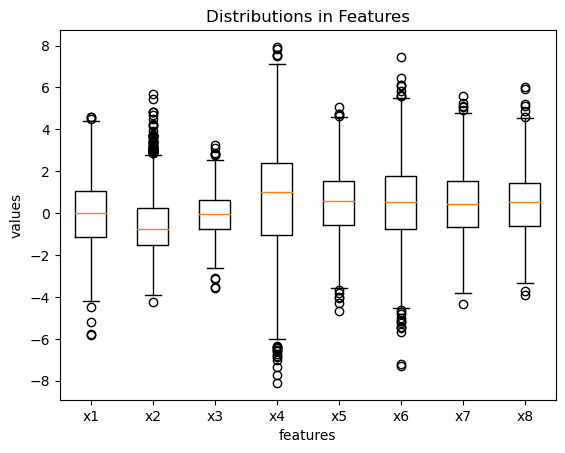

In [9]:
# box plot of features
plt.boxplot(X)
plt.xlabel('features')
plt.ylabel('values')
plt.title('Distributions in Features')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'])
plt.show()

What we need to do now is introduce some missing values, to test that our implementation can handle these.

In [10]:
# add missing values to predictors
X = add_missing_values_to_X(X, n_nan=20)

In [11]:
# add missing values to labels
y = add_missing_values_to_y(y, n_nan=2)

Last step now is to do the train/test split.

In [12]:
# do train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now let's test out our Decision Tree Classifier.

In [13]:
# declare the classifier and train the model
clf = DecisionTreeClassifier(max_depth=5, loss='gini')
clf.train(X_train,y_train)

In [14]:
# generate predictions
yp = clf.predict(X_test)

In [15]:
# evaluate model performance
idx    = ~np.isnan(y_test)
y_test = y_test[idx]
yp     = yp[idx]
print("accuracy: %.2f" % accuracy_score(y_test,yp))
print("precision: %.2f" % precision_score(y_test,yp))
print("recall: %.2f" % recall_score(y_test,yp))

accuracy: 0.85
precision: 0.85
recall: 0.89


We can see that our implementation works, and yields good results. If you try to train the scikit-learn Decision Tree Classifier on these data, you will see it generates a ValueError exception.

### Regression Model

We can repeat the above example, but this time for the Decision Tree Regressor implementation. We can create a simulated dataset consisting of 1000 samples, 8 predictive features, and a single target with gaussian noise introduced. Note that only 5 of the 8 predictive features are informative.

In [16]:
# create a regression dataset
X,y = make_regression(n_samples=1000, n_features=8, n_informative=5, n_targets=1, noise=0.3, random_state=42)

Let's look to see how the predictors and target are distributed.

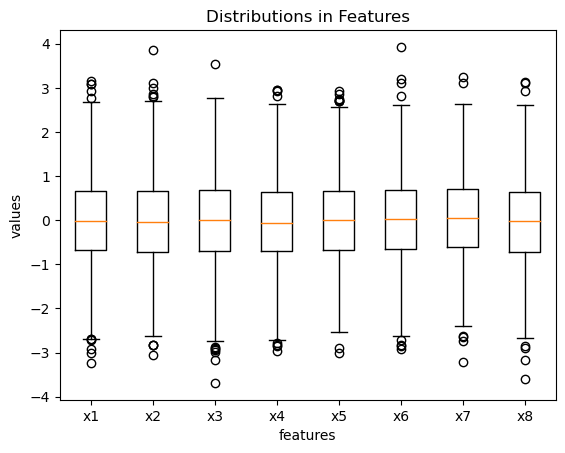

In [17]:
# box plot of features
plt.boxplot(X)
plt.xlabel('features')
plt.ylabel('values')
plt.title('Distributions in Features')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'])
plt.show()

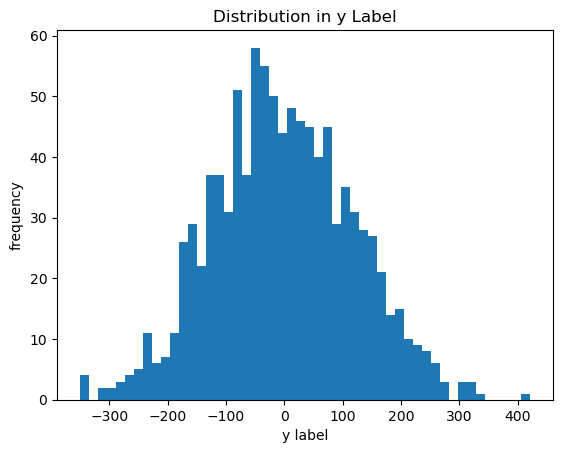

In [18]:
# histogram of label
plt.hist(y,bins=50)
plt.xlabel('y label')
plt.ylabel('frequency')
plt.title('Distribution in y Label')
plt.show()

What we need to do now is introduce some missing values, to test that our implementation can handle these.

In [19]:
# add missing values to predictors
X = add_missing_values_to_X(X, n_nan=5)

In [20]:
# add missing values to labels
y = add_missing_values_to_y(y, n_nan=2)

We can now proceed to do a train-test split.

In [21]:
# do train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now let's test out our Decision Tree Regressor.

In [22]:
# declare the regressor and train the model
rgr = DecisionTreeRegressor(max_depth=5, loss='mae', nans_go_right=False)
rgr.train(X_train,y_train)

In [23]:
# make predictions
yp = rgr.predict(X_test)

In [24]:
# evaluate model performance
idx    = ~np.isnan(y_test)
y_test = y_test[idx]
yp     = yp[idx]
print("rmse: %.2f" % np.sqrt(mean_squared_error(y_test,yp)))
print("mae: %.2f" % mean_absolute_error(y_test,yp))

rmse: 69.51
mae: 53.80


Like before, we can see that our implementation works and yields reasonable results. If you try to train the scikit-learn Decision Tree Regressor on these data, you will see it generates a ValueError exception.